## Assignment 6: Data Exploration & Machine Learning
### CS 640: Bioinformatics
### Submitted By: Melanie Baybay
___

** Instructions: ** 
1. Perform data cleaning.
2. Create two subsets for further exploration: a subset for patients with high warfarin dosage
(0.2 or more standard deviations above the mean) and a subset for patients with low warfarin
dosage (0.2 or more standard deviations below the mean).
3. Display aggregate information on the data (ex: summary in R or describe in Pandas. You may
group by high/low warfarin dosage.
4. Create visualizations of the distributions of key variables by high/low warfarin dosage.
5. Create visualizations of a couple of relationships you find interesting between variables
(ex: scatter plot colored by high/low warfarin dosage).
6. Fit 2 regression models, as described below, to estimate warfarin dosage.
7. Fit an SVM model to classify patients into categories of high/low warfarin dosage
8. Briefly summarize your findings, including a few sentences comparing the summary results and
a plot (ex: Residuals vs Fitted and/or Normal Q-Q) between the two regression models. Also
briefly discuss the SVM classifier.

**Detail on #6:** 
Fit a regression model to predict therapeutic warfarin dose. Let the warfarin dosing estimator
(http://warfarindosing.org/Source/Home.aspx) be your guide as to which variables you should include in
your model. For example, the dataset has two variables for race and two for ethnicity. – you should
include one of each. If you inspect the dosing estimator you should be able to decide which variable for
race and which for ethnicity you should use. For incorporation of age, you may create a numeric
variable that holds age as the number of decades for that patient. (You can use substr for this).
For medications the patient is taking, you should include in your prediction Boolean variables to indicate
a) whether the patient is taking Amiodarone, and b) whether the patient is taking an Enzyme Inducer
(rifampin, carbamazepine, phenytoin or rifampicin). To create these boolean columns you can detect the
indicated substring(s) (ex: rifampin or carbamazepine or phenytoin or rifampicin) in the medication
column. (You can use grep or str_detect from package stringr).
Fit a second regression model that is the same as the first, except replace response variable therapeutic
warfarin dose with square root of therapeutic warfarin dose. (ie: use the same predictor variables).

---

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Data Cleaning

In [2]:
raw_df = pd.read_csv('iwpc_warfarin.txt', sep='\t')

In [3]:
raw_df.head()

,PharmGKB Subject ID,PharmGKB Sample ID,Project Site,Gender,Race (Reported),Race (OMB),Ethnicity (Reported),Ethnicity (OMB),Age,Height (cm),...,Comorbidities,Medications,Target INR,Estimated Target INR Range Based on Indication,Subject Reached Stable Dose of Warfarin,Therapeutic Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Current Smoker,CYP2C9 consensus,VKORC1 -1639 consensus
0,PA135312261,PA135312629,1,male,White,White,not Hispanic or Latino,not Hispanic or Latino,60 - 69,193.04,...,No Cancer,aspirin; not simvastatin; not amiodarone,2.5,NaN,1.0,49.0,2.60,0.0,*1/*1,A/G
1,PA135312262,PA135312630,1,female,White,White,not Hispanic or Latino,not Hispanic or Latino,50 - 59,176.53,...,Cancer,not aspirin; not simvastatin; not amiodarone,2.5,NaN,1.0,42.0,2.15,1.0,*1/*1,A/A
2,PA135312263,PA135312631,1,female,White,White,not Hispanic or Latino,not Hispanic or Latino,40 - 49,162.56,...,No Cancer,not aspirin; not simvastatin; not amiodarone,2.5,NaN,1.0,53.0,1.90,0.0,*1/*1,G/G
3,PA135312264,PA135312632,1,male,White,White,not Hispanic or Latino,not Hispanic or Latino,60 - 69,182.24,...,No Cancer,not aspirin; not simvastatin; not amiodarone,2.5,NaN,1.0,28.0,2.40,0.0,*1/*1,A/G
4,PA135312265,PA135312633,1,male,White,White,not Hispanic or Latino,not Hispanic or Latino,50 - 59,167.64,...,No Cancer,not aspirin; not simvastatin; not amiodarone,2.5,NaN,1.0,42.0,1.90,0.0,*1/*3,A/G


In [4]:
raw_df.dtypes

PharmGKB Subject ID                                object
PharmGKB Sample ID                                 object
Project Site                                        int64
Gender                                             object
Race (Reported)                                    object
Race (OMB)                                         object
Ethnicity (Reported)                               object
Ethnicity (OMB)                                    object
Age                                                object
Height (cm)                                       float64
Weight (kg)                                       float64
Indication for Warfarin Treatment                  object
Comorbidities                                      object
Medications                                        object
Target INR                                        float64
Estimated Target INR Range Based on Indication     object
Subject Reached Stable Dose of Warfarin           float64
Therapeutic Do

In [5]:
raw_df.drop(["PharmGKB Subject ID", "PharmGKB Sample ID", "Project Site"], axis=1, inplace=True)

### Check for Outliers or Incorrect Values

In [6]:
raw_df["Age"].unique()

array(['60 - 69', '50 - 59', '40 - 49', '70 - 79', '30 - 39', '80 - 89',
       '90+', '20 - 29', '19-Oct', nan], dtype=object)

In [7]:
raw_df.loc[raw_df.Age == '19-Oct', "Age"] = np.nan
# raw_df.Age = pd.Categorical(raw_df.Age, ordered=False)

In [8]:
raw_df["VKORC1 -1639 consensus"].unique()

array(['A/G', 'A/A', 'G/G', nan], dtype=object)

In [9]:
# raw_df["VKORC1 -1639 consensus"] = pd.Categorical(raw_df["VKORC1 -1639 consensus"], ordered=False)

In [10]:
raw_df["CYP2C9 consensus"].unique()

array(['*1/*1', '*1/*3', '*1/*2', '*2/*2', '*2/*3', '*3/*3', nan, '*1/*5',
       '*1/*13', '*1/*14', '*1/*11', '*1/*6'], dtype=object)

In [11]:
# raw_df["CYP2C9 consensus"] = pd.Categorical(raw_df["CYP2C9 consensus"], ordered=False)

In [12]:
raw_df["Race (Reported)"].unique()

array(['White', 'Other Mixed Race', 'African-American', 'Black',
       'Hispanic', 'Japanese', 'Han Chinese', 'other', nan, 'Asian',
       'Korean', 'Caucasian', 'Black or African American', 'Other',
       'Intermediate', 'Malay', 'Chinese', 'Indian', 'Black Caribbean',
       'Other (Hungarian)', 'Other (Black British)', 'Black African',
       'Black other'], dtype=object)

In [13]:
raw_df["Race (OMB)"].unique()

array(['White', 'Unknown', 'Black or African American', 'Asian'], dtype=object)

In [14]:
raw_df["Ethnicity (Reported)"].unique()

array(['not Hispanic or Latino', 'Latino or Hispanic', 'Hispanic',
       'Han Chinese', 'nonHispanic', nan, 'Hispanic or Latino', 'White',
       'Israel', 'East Europe', 'North America', 'kurdish and Irak',
       'North Africa', 'Arabic Muslim', 'South Africa', 'egypt', 'spain',
       'West Europe', 'syria', 'Persia', 'NewZyland', 'Turkey',
       'S. America', 'arabic christian', 'spharadic', 'yaman', 'hungary'], dtype=object)

In [15]:
raw_df["Ethnicity (OMB)"].unique()

array(['not Hispanic or Latino', 'Hispanic or Latino', 'Unknown'], dtype=object)

In [16]:
raw_df['Medications'].unique()

array(['aspirin; not simvastatin; not amiodarone',
       'not aspirin; not simvastatin; not amiodarone',
       'not aspirin; simvastatin; not amiodarone', ...,
       'Aspirin and/or palvix and/or  dipyridamole; inhibit2c9; amiodarone',
       'Aspirin and/or palvix and/or  dipyridamole; inhibit2c9; amiodarone; statin',
       'Aspirin and/or palvix and/or  dipyridamole; substrate2c9'], dtype=object)

In [17]:
raw_df['Indication for Warfarin Treatment'].unique()

array(['7', '3', '8', '1', '2', '4', '5', '6', '4; 8', '3; 8', '3; 4',
       '3; 4; 8', '1; 6', '7; 8', '3; 6', '3; 6; 8', '6; 8', '4; 7',
       '3; 4; 6; 8', '1; 3; 8', '3; 4; 6', nan, '3; 4; 7; 8', '4; 6',
       '2; 8', '3; 4; 6; 7; 8', '3; 4; 7', '4; 7; 8', '1; 2', '1; 8',
       '4; 6; 8', '1; 2; 8', '2; 3; 8', '3; 6; 7', '3; 7', '3; 7; 8',
       '1;2', '4;6', '5; 8', '1; 3', '2; 3', '4; 5', '3; 5', '1; 2; 3',
       '5; 6', '1; 3; 4; 8', '1; 2; 5; 8', '1 or 2', '4; 3', '3; 2',
       '6; 5', '1,2', '2; 6'], dtype=object)

In [18]:
raw_df.describe()

,Height (cm),Weight (kg),Target INR,Subject Reached Stable Dose of Warfarin,Therapeutic Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Current Smoker
count,4554.000000,5413.000000,1259.000000,5651.000000,5528.000000,4968.000000,3220.000000
mean,168.047811,77.853057,2.538324,0.960007,30.977873,2.364436,0.139441
std,10.846051,21.860018,0.198140,0.195960,16.801040,0.464645,0.346460
min,124.970000,30.000000,1.300000,0.000000,2.100000,0.800000,0.000000
25%,160.020000,62.000000,2.500000,1.000000,19.530000,2.100000,0.000000
50%,167.890000,75.000000,2.500000,1.000000,28.000000,2.400000,0.000000
75%,176.020000,90.000000,2.500000,1.000000,38.500000,2.610000,0.000000
max,202.000000,237.700000,3.500000,1.000000,315.000000,6.100000,1.000000


### Create High & Low Warfarin Dose Subsets

In [19]:
def id_dose_type(dose, thres):
    if dose >= thres:
        return "High"
    else:
        return "Low"

# thres = .2 standard deviations above the mean
thres = 0.2 * raw_df["Therapeutic Dose of Warfarin"].std() + raw_df["Therapeutic Dose of Warfarin"].mean()
raw_df["Dose Type"] = raw_df["Therapeutic Dose of Warfarin"].apply(id_dose_type, args=[thres]).astype("category")

In [20]:
# warf_df["Dose_Type_encoded"] = raw_df["Dose Type"].apply(lambda x: 1 if x == "High" else 0)

### Data Summaries

In [21]:
raw_df[raw_df["Dose Type"] == "High"].describe()

,Height (cm),Weight (kg),Target INR,Subject Reached Stable Dose of Warfarin,Therapeutic Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Current Smoker
count,1651.000000,1964.000000,655.000000,2044.000000,2044.000000,1873.000000,1453.000000
mean,172.340581,87.561405,2.551985,0.984344,47.496067,2.454592,0.172058
std,10.222354,23.482079,0.212986,0.124169,15.634492,0.396229,0.377561
min,140.460000,38.000000,1.750000,0.000000,34.500000,0.800000,0.000000
25%,165.100000,71.175000,2.500000,1.000000,37.500000,2.200000,0.000000
50%,172.720000,84.000000,2.500000,1.000000,42.500000,2.500000,0.000000
75%,180.340000,99.800000,2.500000,1.000000,52.500000,2.700000,0.000000
max,202.000000,237.700000,3.500000,1.000000,315.000000,6.100000,1.000000


Notes: 
- Race: 0 for more than 50%, 1 for more than 75%

In [22]:
raw_df[raw_df["Dose Type"] == "Low"].describe()

,Height (cm),Weight (kg),Target INR,Subject Reached Stable Dose of Warfarin,Therapeutic Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Current Smoker
count,2903.000000,3449.000000,604.000000,3607.000000,3484.000000,3095.000000,1767.000000
mean,165.606417,72.324732,2.523510,0.946216,21.286946,2.309877,0.112620
std,10.426034,18.758182,0.179672,0.225623,7.105389,0.493663,0.316218
min,124.970000,30.000000,1.300000,0.000000,2.100000,0.850000,0.000000
25%,157.990000,59.000000,2.500000,1.000000,17.000000,2.000000,0.000000
50%,165.100000,70.000000,2.500000,1.000000,21.000000,2.360000,0.000000
75%,172.970000,82.600000,2.500000,1.000000,27.500000,2.600000,0.000000
max,200.660000,215.500000,3.500000,1.000000,34.040000,5.100000,1.000000


### Visualize Distributions

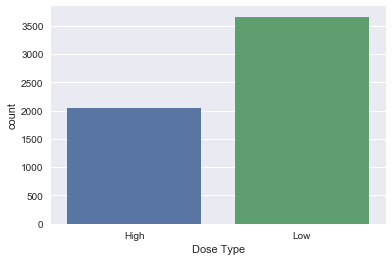

In [23]:
sns.countplot("Dose Type", data=raw_df)

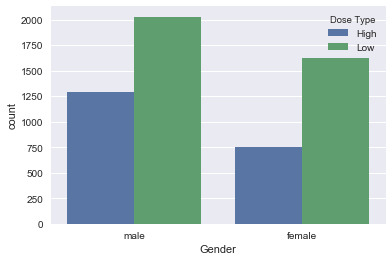

In [24]:
sns.countplot("Gender", data=raw_df, hue="Dose Type")

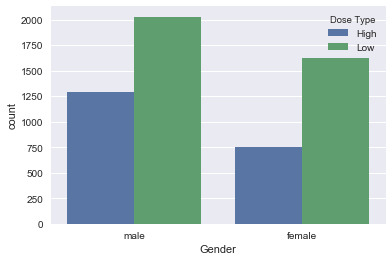

In [25]:
sns.countplot("Gender", data=raw_df, hue="Dose Type")

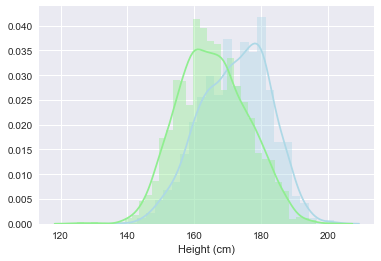

In [26]:
sns.distplot(raw_df[raw_df["Dose Type"] == "High"]["Height (cm)"].dropna(), color="lightblue")
sns.distplot(raw_df[raw_df["Dose Type"] == "Low"]["Height (cm)"].dropna(), color="lightgreen")

Note: Lower dosage often given for smaller height, high dosage often for taller height.

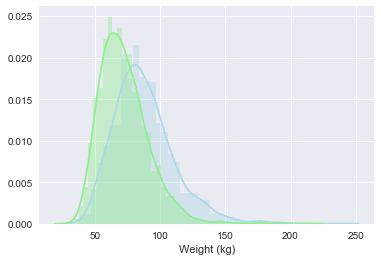

In [27]:
sns.distplot(raw_df[raw_df["Dose Type"] == "High"]["Weight (kg)"].dropna(), color="lightblue")
sns.distplot(raw_df[raw_df["Dose Type"] == "Low"]["Weight (kg)"].dropna(), color="lightgreen")

Note: Lower dosage often given for lighter weight, higher dosage given for slightly higher weight

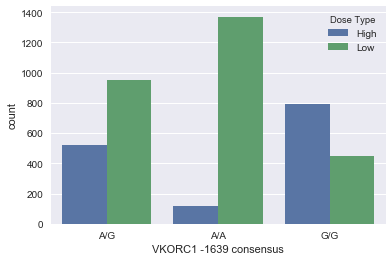

In [28]:
sns.countplot("VKORC1 -1639 consensus", data=raw_df, hue="Dose Type")

Note: Low dosage clearly common for A/A, High dosage common for G/G. **What populations are more likely to have A variant for VKORC1?**

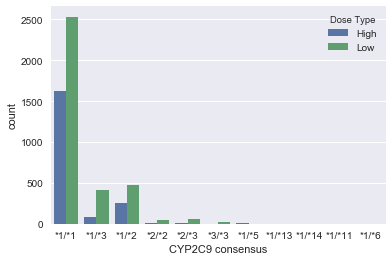

In [29]:
sns.countplot("CYP2C9 consensus", data=raw_df, hue="Dose Type")

Note: Low dose seen most for those with \*1: \*1/\*1, \*1/\*2, \*1/\*3.

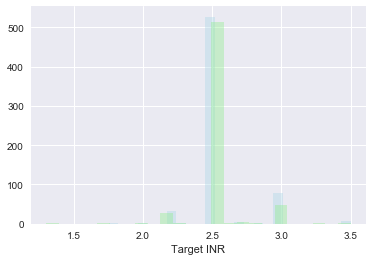

In [30]:
sns.distplot(raw_df[raw_df["Dose Type"] == "High"]["Target INR"].dropna(), color="lightblue", kde=False)
sns.distplot(raw_df[raw_df["Dose Type"] == "Low"]["Target INR"].dropna(), color="lightgreen", kde=False)

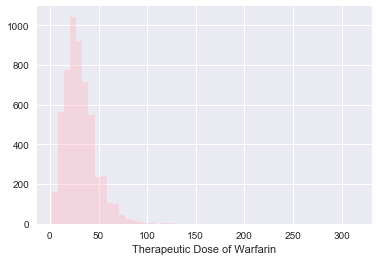

In [31]:
sns.distplot(raw_df["Therapeutic Dose of Warfarin"].dropna(), color="lightpink", kde=False)

Why does the range go up to 300? Is there an outlier?

In [32]:
raw_df[raw_df["Therapeutic Dose of Warfarin"] > 150]["Therapeutic Dose of Warfarin"]

3902    230.0
4162    157.5
4246    315.0
Name: Therapeutic Dose of Warfarin, dtype: float64

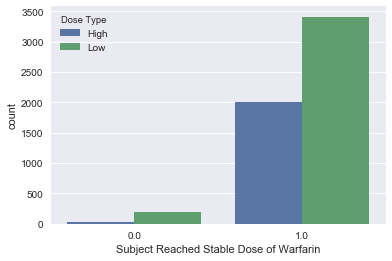

In [33]:
sns.countplot("Subject Reached Stable Dose of Warfarin", data=raw_df, hue="Dose Type")

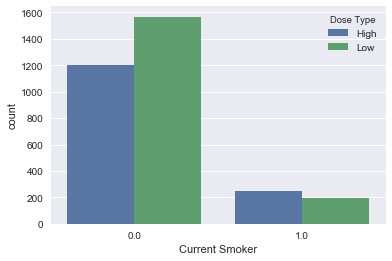

In [34]:
sns.countplot("Current Smoker", data=raw_df, hue="Dose Type")

Based on the plots, I wonder if the high values of low dose type is because there are significantly more cases of it. Will we get similar results if we downsample the low dose cases?

In [35]:
sampled = raw_df[raw_df["Dose Type"] == "Low"].sample(n=2044)
sampled = sampled.append(raw_df[raw_df["Dose Type"] == "High"])
sampled.sort_index(inplace=True)

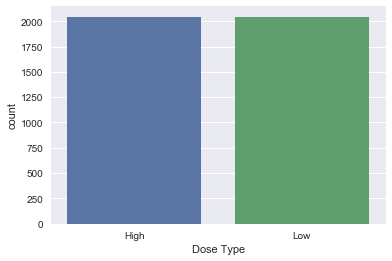

In [36]:
sns.countplot("Dose Type", data=sampled)

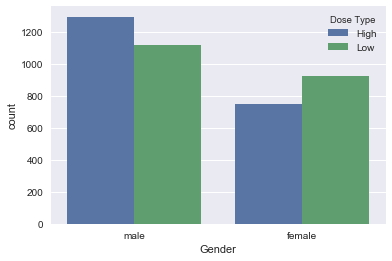

In [37]:
sns.countplot("Gender", data=sampled, hue="Dose Type")

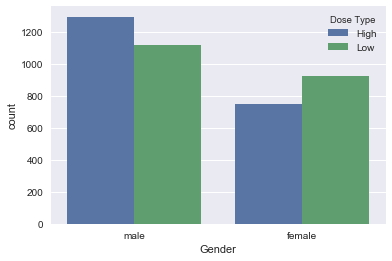

In [38]:
sns.countplot("Gender", data=sampled, hue="Dose Type")

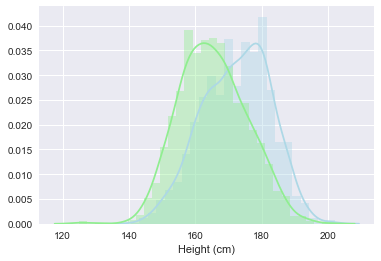

In [39]:
sns.distplot(sampled[sampled["Dose Type"] == "High"]["Height (cm)"].dropna(), color="lightblue")
sns.distplot(sampled[sampled["Dose Type"] == "Low"]["Height (cm)"].dropna(), color="lightgreen")

Note: Same; Lower dosage often given for smaller height, high dosage often for taller height.

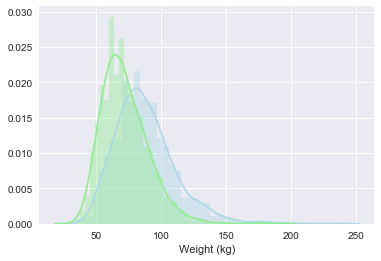

In [40]:
sns.distplot(sampled[sampled["Dose Type"] == "High"]["Weight (kg)"].dropna(), color="lightblue")
sns.distplot(sampled[sampled["Dose Type"] == "Low"]["Weight (kg)"].dropna(), color="lightgreen")

Note: Same; Lower dosage often given for lighter weight, higher dosage given for slightly higher weight

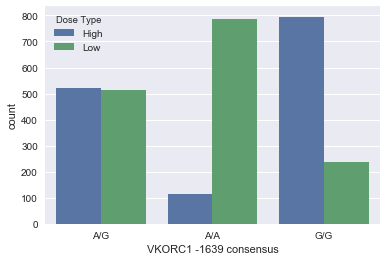

In [41]:
sns.countplot("VKORC1 -1639 consensus", data=sampled, hue="Dose Type")

Note: Low dosage clearly common for A/A, High dosage common for G/G. **What populations are more likely to have A variant for VKORC1?**

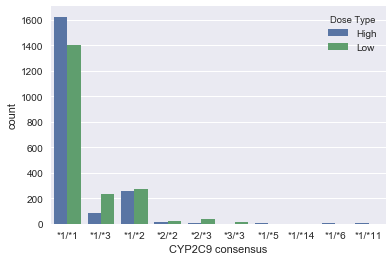

In [42]:
sns.countplot("CYP2C9 consensus", data=sampled, hue="Dose Type")

Note: Different; High dose only slightly greater for \*1/\*1...

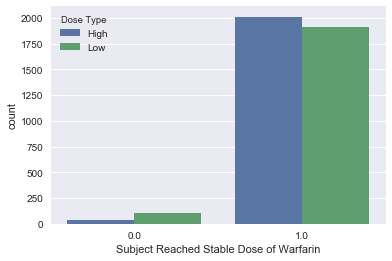

In [43]:
sns.countplot("Subject Reached Stable Dose of Warfarin", data=sampled, hue="Dose Type")

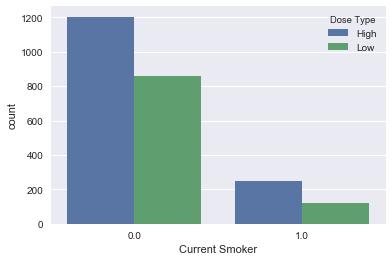

In [44]:
sns.countplot("Current Smoker", data=sampled, hue="Dose Type")

### Insights:
- A/A for Low Dose, G/G for High Dose, about '50/50' between low and high for A/G

I'd like to investigate if there is some relationship between VKORC1 and dempgraphic characteristics such as Race. There might be key factors in these demographics that attribute to having A/A or A/G.

---

# Visualization Set A
1. Distribution of Race and VKORC1. 
2. Distribution of Race and CYP2C9.

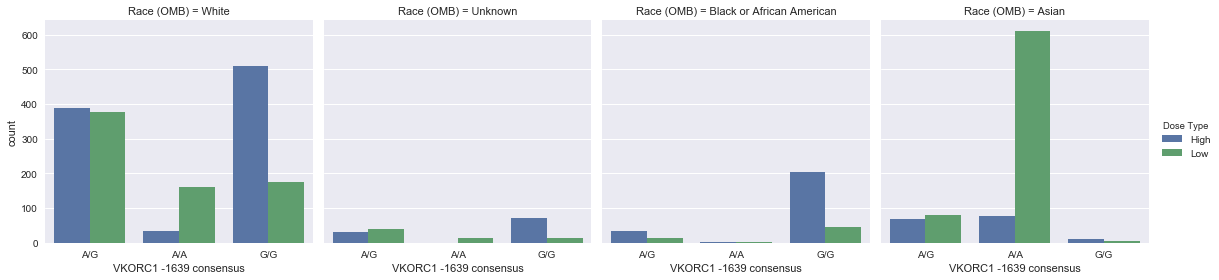

In [45]:
sns.factorplot(x="VKORC1 -1639 consensus", col= "Race (OMB)", hue="Dose Type", kind="count", data=sampled)

### Insights: 
* **Low Dose** is most significant given for **Asians w/ A/A VKORC1**. 
* Other cases of low dose: 
    * **Asians w/ A/G**
    * **Whites w/ A/A**
* **High Dose** is common most significant for **Whites w/ G/G** and **Black/African American w/ G/G**
* Black/African American population has low frequency of A/A overall

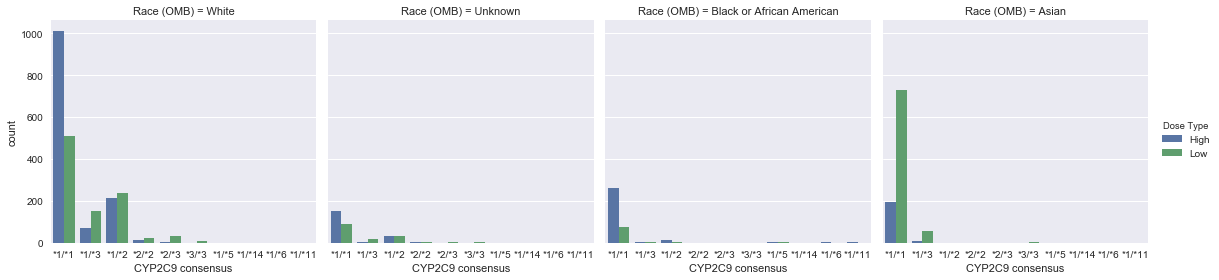

In [46]:
sns.factorplot(x='CYP2C9 consensus', col= "Race (OMB)", hue="Dose Type", kind="count", data=sampled)

### Insights:
* Low Dose most significant for **Asians w/ \*1/\*1 CYP2C9**
* Other Low Dose Cases: 
    * **Asians w/ \*1/\*3**
    * **Whites w/ \*1/\*3**
* High Dose is most significant for **Whites w/ \*1/\*1** and **Black/African Americans w/ \*1/\*1** in this sampled set.

<br>
<br>

Since overall counts vary for difference race types, it's possible that results for VKORC1 and CYP2C9 may be skewed. To double check, we can take samples of 100 people for each race and plot the results, as shown below: 

In [47]:
sampled_by_race = sampled[sampled["Race (OMB)"] == "Asian"].sample(n=100)
sampled_by_race = sampled_by_race.append(sampled[sampled["Race (OMB)"] == "White"].sample(n=100))
sampled_by_race = sampled_by_race.append(sampled[sampled["Race (OMB)"] == "Black or African American"].sample(n=100))
sampled_by_race = sampled_by_race.append(sampled[sampled["Race (OMB)"] == "Unknown"].sample(n=100))

Display some of random sample

In [48]:
sampled_by_race[['Race (OMB)', 'CYP2C9 consensus', 'VKORC1 -1639 consensus']].sample(5)

,Race (OMB),CYP2C9 consensus,VKORC1 -1639 consensus
3453,Black or African American,*1/*1,G/G
621,Asian,*1/*1,A/G
5265,White,*1/*1,G/G
3918,Black or African American,NaN,G/G
4484,Black or African American,*1/*1,G/G


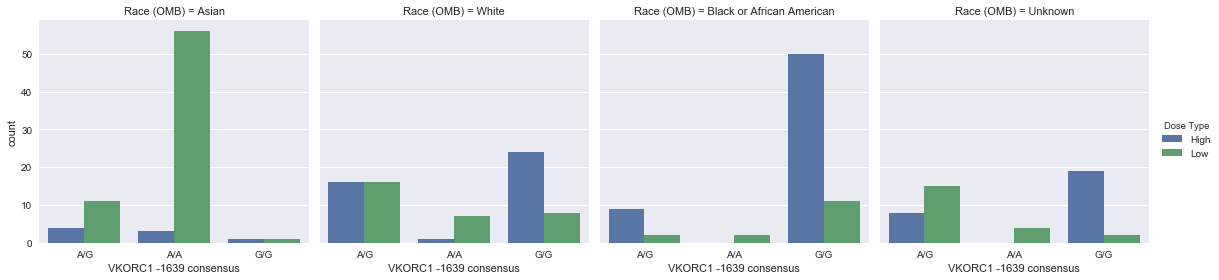

In [49]:
sns.factorplot(x="VKORC1 -1639 consensus", col= "Race (OMB)", hue="Dose Type", kind="count", data=sampled_by_race, hue_order=["High", "Low"])

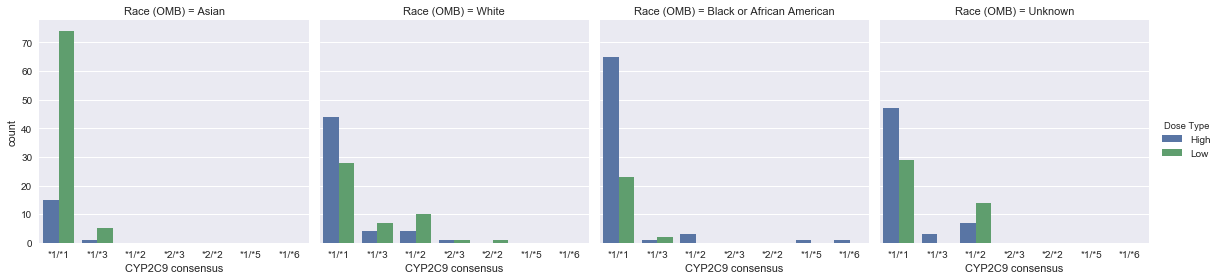

In [50]:
sns.factorplot(x='CYP2C9 consensus', col= "Race (OMB)", hue="Dose Type", kind="count", data=sampled_by_race, hue_order=["High", "Low"])

<br>
* **Low Dose** is most significant given for **Asians w/ A/A VKORC1**. 
* Other cases of low dose: 
    * **Asians w/ A/G**
    * **Whites w/ A/A**
* **High Dose** is common most significant for **Whites w/ G/G** and **Black/African American w/ G/G**
* Black/African American population has low frequency of A/A overall

Interestingly, for both plots of the sampled by race dataset we see the same findings: 
* Low Dose common for Asians with A/A VKORC1 and/or \*1/\*1 CYP2C9
* High Dose for Whites and Black/African Americans with G/G VKORC1 and/or \*1/\*1 CYP2C9

<br>

It would be interesting to see a heatmap of of dosage and these two genes against race. 

In [51]:
race_genes = sampled.groupby(["Race (OMB)", "CYP2C9 consensus", "VKORC1 -1639 consensus", "Dose Type"])["Dose Type"].agg(["count"])

In [52]:
pivot_df = pd.pivot_table(race_genes.reset_index(),
                          values=['count'],
                          columns=['Race (OMB)'], 
                          index=["Dose Type", "CYP2C9 consensus", "VKORC1 -1639 consensus"])
pivot_df.head()

count  \
Race (OMB)                                        Asian   
Dose Type CYP2C9 consensus VKORC1 -1639 consensus         
High      *1/*1            A/A                     74.0   
                           A/G                     68.0   
                           G/G                     10.0   
          *1/*11           A/A                      NaN   
                           A/G                      NaN   

                                                                             \
Race (OMB)                                        Black or African American   
Dose Type CYP2C9 consensus VKORC1 -1639 consensus                             
High      *1/*1            A/A                                          NaN   
                           A/G                                         33.0   
                           G/G                                        180.0   
          *1/*11           A/A                                          NaN   
                           A/G                                          NaN   

                                                                  
Race (OMB)                                        Unknown  White  
Dose Type CYP2C9 consensus VKORC1 -1639 consensus                 
High      *1/*1            A/A                        NaN   26.0  
                           A/G                       24.0  297.0  
                           G/G                       57.0  380.0  
          *1/*11           A/A                        NaN    NaN  
                           A/G                        NaN    1.0

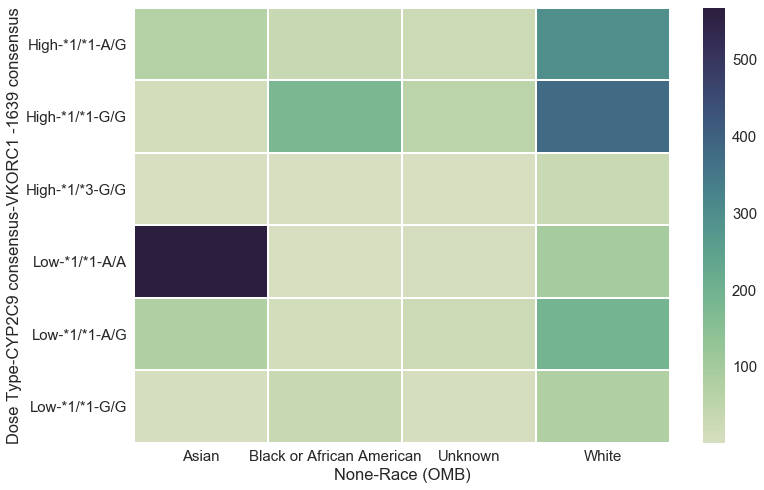

In [53]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_df.dropna(), cmap=sns.cubehelix_palette(10, start=.5, rot=-.75, as_cmap=True), linewidths=1, ax=ax)
ax.set_xticklabels(['Asian', 'Black or African American', 'Unknown', 'White'])

- Even clearer, we can see **low dosage** is common for Asians with \*1/\*1 AND A/A.
- For African Americans and Whites, it is common to have a **high dosage** with \*1/\*1 and G/G. 

<br>
Now, let's try to see if we can fit linear regression models to predict therapeutic dose.

---

# Predicting Therapeutic Dosage

### Encoded Copy of Data based on [warfarin_vars.txt](warfarin_vars.txt)

In [54]:
raw_df.Comorbidities.unique()

array(['No Cancer', 'Cancer', nan, ...,
       'high cholesterol; atrial fibrilation; congestive heart failure; coronary artery disease; myocardial infarction; coronary artery bypass surgery; stent; diabetes mellitus; renal insufficiency',
       'hypertension; high cholesterol; congestive heart failure; coronary artery disease; diabetes mellitus; renal insufficiency',
       'hypertension; high cholesterol; cancer'], dtype=object)

In [55]:
warf_df = pd.DataFrame(raw_df[["Height (cm)", "Weight (kg)", "Target INR", "Therapeutic Dose of Warfarin", "Subject Reached Stable Dose of Warfarin", "Current Smoker"]])
# warf_df = pd.DataFrame(raw_df[["Therapeutic Dose of Warfarin"]])

Copy continuos variables 

In [56]:
def encode(val, ref, invalid):
    if val in ref.keys():
        return ref[val]
    else:
        return invalid

Encode age based on decade, fill as 0 if unknown

In [57]:
age_ref = {"10 - 19": 1, "20 - 29": 2, "30 - 39": 3, "40 - 49": 4, 
            "50 - 59": 5, "60 - 69": 6, "70 - 79": 7, "80 - 89": 8, 
            "90+": 9}
warf_df["Age"] = raw_df["Age"].apply(encode, args=(age_ref, 0)).astype('int')
# warf_df.head()

Encode VKORC1, fill as 0 otherwise

In [58]:
warf_df["VKORC1_AG"] = raw_df["VKORC1 -1639 consensus"].apply(lambda x: 1 if x == "A/G" else 0).astype('int')
warf_df["VKORC1_AA"] = raw_df["VKORC1 -1639 consensus"].apply(lambda x: 1 if x == "A/A" else 0).astype('int')
# warf_df.head()

Encode CYP2C9, fill as 0 otherwise

In [59]:
warf_df["CYP2C9_12"] = raw_df["CYP2C9 consensus"].apply(lambda x: 1 if x == "*1/*2" else 0).astype('int')
warf_df["CYP2C9_13"] = raw_df["CYP2C9 consensus"].apply(lambda x: 1 if x == "*1/*3" else 0).astype('int')
warf_df["CYP2C9_22"] = raw_df["CYP2C9 consensus"].apply(lambda x: 1 if x == "*2/*2" else 0).astype('int')
warf_df["CYP2C9_23"] = raw_df["CYP2C9 consensus"].apply(lambda x: 1 if x == "*2/*3" else 0).astype('int')
warf_df["CYP2C9_33"] = raw_df["CYP2C9 consensus"].apply(lambda x: 1 if x == "*3/*3" else 0).astype('int')
warf_df["CYP2C9_unknown"] = raw_df["CYP2C9 consensus"].apply(lambda x: 1 if x == np.nan else 0).astype('int')
# warf_df.head()

Encode race, fill with 0 if not in reference

In [60]:
asian = ['Japanese', 'Han Chinese', 'Asian','Korean', 'Malay', 'Chinese', 'Indian']
black = ['African-American', 'Black','Black or African American','Black Caribbean','Other (Black British)',
         'Black African','Black other']
missing_mixed = ['Other Mixed Race','other', np.nan,'Other','Intermediate']
warf_df["Asian"] = raw_df["Race (Reported)"].apply(lambda x: 1 if x in asian else 0).astype('int')
warf_df["Black"] = raw_df["Race (Reported)"].apply(lambda x: 1 if x in black else 0).astype('int')
warf_df["Missing_Mixed"] = raw_df["Race (Reported)"].apply(lambda x: 1 if x in missing_mixed else 0).astype('int')
# warf_df.head()

Encode ethnicity, fill with 0 if not in reference

In [61]:
ethnicity = {'not Hispanic or Latino':1 , 'Hispanic or Latino': 2, 'Unknown': 0}
warf_df["Ethnicity_encoded"] = raw_df["Ethnicity (OMB)"].apply(encode, args=[ethnicity, 0]).astype('int')

In [62]:
def encode_amiodarone(med_str): 
    if isinstance(med_str, str):
        med_list = med_str.split(";")
        if 'amiodarone' in med_list: 
            return 1
    return 0 # not string or no amidarone

warf_df["Amiodarone_status"] = raw_df["Medications"].apply(encode_amiodarone).astype('int')
# warf_df.head()
# warf_df[warf_df["Amiodarone_status"] == 1] 

In [63]:
def encode_enzyme_inducer_status(med_str):
    enz_ind_ref = ["rifampin", "carbamazepine", "phenytoin", "rifampicin"]
    if isinstance(med_str, str):
        med_list = med_str.split(";")
        for med in med_list: 
            if med in enz_ind_ref: 
                return 1
    return 0

warf_df["Enzyme_inducer_status"] = raw_df["Medications"].apply(encode_enzyme_inducer_status).astype('int')
# warf_df.head()
# warf_df[warf_df["Enzyme_inducer_status"] == 1][["Medications", "Enzyme_inducer_status"]]

In [64]:
indications = []
for inds in raw_df["Indication for Warfarin Treatment"].dropna().unique():
    ind_list = inds.replace(" ", "").split(";")
    for ind in ind_list:
        if (ind == '1or2') or (ind == '1,2'):
            continue
        if ind not in indications:
            indications.append(ind)

ind_names = ["Indication_{}".format(x) for x in indications]
ind_dict = dict(zip(ind_names, indications))

pd.concat([warf_df, pd.DataFrame(columns=ind_names)])

def encode_indication(ind_str, indication):
    if isinstance(ind_str, str):
        ind_list = ind_str.replace(" ", "").split(";")
        for ind in ind_list: 
            if ind == indication:
                return 1
    return 0


for col in ind_names:
    warf_df[col] = raw_df["Indication for Warfarin Treatment"].apply(encode_indication, args=[ind_dict[col]])

In [65]:
warf_df.head(5)

,Height (cm),Weight (kg),Target INR,Therapeutic Dose of Warfarin,Subject Reached Stable Dose of Warfarin,Current Smoker,Age,VKORC1_AG,VKORC1_AA,CYP2C9_12,...,Amiodarone_status,Enzyme_inducer_status,Indication_7,Indication_3,Indication_8,Indication_1,Indication_2,Indication_4,Indication_5,Indication_6
0,193.04,115.7,2.5,49.0,1.0,0.0,6,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,176.53,144.2,2.5,42.0,1.0,1.0,5,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,162.56,77.1,2.5,53.0,1.0,0.0,4,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,182.24,90.7,2.5,28.0,1.0,0.0,6,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,167.64,72.6,2.5,42.0,1.0,0.0,5,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [66]:
# comorbidities = []
# for diseases in raw_df.Comorbidities.dropna().unique():
#     disease_list = diseases.split(";")
#     for disease in disease_list:
#         if disease.upper() not in comorbidities:
#             comorbidities.append(disease.upper())
            
def encode_liver_disease(comorbid_str): 
    if isinstance(comorbid_str, str):
        disease_list = comorbid_str.split(";")
        for disease in disease_list: 
            if disease == 'LIVER DISEASE': 
                return 1
    return 0
warf_df["Liver Disease"] = raw_df["Comorbidities"].apply(encode_liver_disease).astype('int')

Convert 'Stable Dose' and 'Current Smoker' types to boolean. 

In [67]:
warf_df["Subject Reached Stable Dose of Warfarin"] = raw_df["Subject Reached Stable Dose of Warfarin"].astype('bool')

In [68]:
warf_df["Current Smoker"] = raw_df["Current Smoker"].astype('bool')

In [69]:
warf_df.dtypes

Height (cm)                                float64
Weight (kg)                                float64
Target INR                                 float64
Therapeutic Dose of Warfarin               float64
Subject Reached Stable Dose of Warfarin       bool
Current Smoker                                bool
Age                                          int64
VKORC1_AG                                    int64
VKORC1_AA                                    int64
CYP2C9_12                                    int64
CYP2C9_13                                    int64
CYP2C9_22                                    int64
CYP2C9_23                                    int64
CYP2C9_33                                    int64
CYP2C9_unknown                               int64
Asian                                        int64
Black                                        int64
Missing_Mixed                                int64
Ethnicity_encoded                            int64
Amiodarone_status              

In [70]:
warf_df.describe()

,Height (cm),Weight (kg),Target INR,Therapeutic Dose of Warfarin,Age,VKORC1_AG,VKORC1_AA,CYP2C9_12,CYP2C9_13,CYP2C9_22,...,Enzyme_inducer_status,Indication_7,Indication_3,Indication_8,Indication_1,Indication_2,Indication_4,Indication_5,Indication_6,Liver Disease
count,4554.000000,5413.000000,1259.000000,5528.000000,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000,...,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000,5700.0
mean,168.047811,77.853057,2.538324,30.977873,5.877895,0.257895,0.260526,0.129298,0.087368,0.009825,...,0.000877,0.023158,0.391404,0.178947,0.075088,0.064386,0.192281,0.022281,0.038421,0.0
std,10.846051,21.860018,0.198140,16.801040,1.561233,0.437514,0.438960,0.335559,0.282399,0.098639,...,0.029607,0.150418,0.488107,0.383342,0.263556,0.245461,0.394127,0.147608,0.192227,0.0
min,124.970000,30.000000,1.300000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,160.020000,62.000000,2.500000,19.530000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,167.890000,75.000000,2.500000,28.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,176.020000,90.000000,2.500000,38.500000,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,202.000000,237.700000,3.500000,315.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


Filter Dataset

In [71]:
warf_df.columns

Index(['Height (cm)', 'Weight (kg)', 'Target INR',
       'Therapeutic Dose of Warfarin',
       'Subject Reached Stable Dose of Warfarin', 'Current Smoker', 'Age',
       'VKORC1_AG', 'VKORC1_AA', 'CYP2C9_12', 'CYP2C9_13', 'CYP2C9_22',
       'CYP2C9_23', 'CYP2C9_33', 'CYP2C9_unknown', 'Asian', 'Black',
       'Missing_Mixed', 'Ethnicity_encoded', 'Amiodarone_status',
       'Enzyme_inducer_status', 'Indication_7', 'Indication_3', 'Indication_8',
       'Indication_1', 'Indication_2', 'Indication_4', 'Indication_5',
       'Indication_6', 'Liver Disease'],
      dtype='object')

In [72]:
warf_df.shape

(5700, 30)

In [73]:
warf_df.fillna(0, inplace=True)

In [74]:
warf_df.shape

(5700, 30)

## Linear Regression (Ordinary Least Squares)

In [75]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(warf_df, test_size=0.2)
print(len(train), len(test))

4560 1140


In [76]:
train_y = train['Therapeutic Dose of Warfarin']
train_X = train.drop('Therapeutic Dose of Warfarin', axis=1)
test_y = test['Therapeutic Dose of Warfarin']
test_X = test.drop('Therapeutic Dose of Warfarin', axis=1)

In [77]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
pred = lr.predict(test_X)

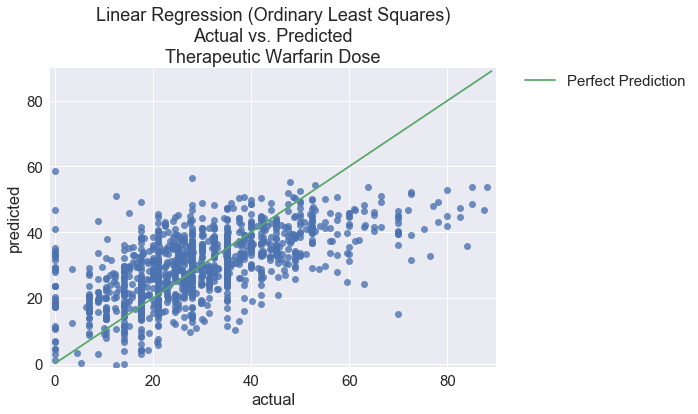

In [79]:
g = sns.regplot(test_y, pred, fit_reg=False)
g.set_xlabel("actual")
g.set_ylabel("predicted")
g.set_xlim(left=-1, right=90)
g.set_ylim(bottom = -1, top=90)
line = plt.plot(range(0, 90), label="Perfect Prediction")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_title("Linear Regression (Ordinary Least Squares)\nActual vs. Predicted\nTherapeutic Warfarin Dose")

In [80]:
lr_score = lr.score(test_X, test_y)
print("R2 coefficient: {}".format(lr_score))

R2 coefficient: 0.401175644138838


## Linear Regression (ElasticNet)

In [81]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(alpha=1, l1_ratio=1, random_state=0)
en.fit(train_X, train_y)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [82]:
pred_en = en.predict(test_X)

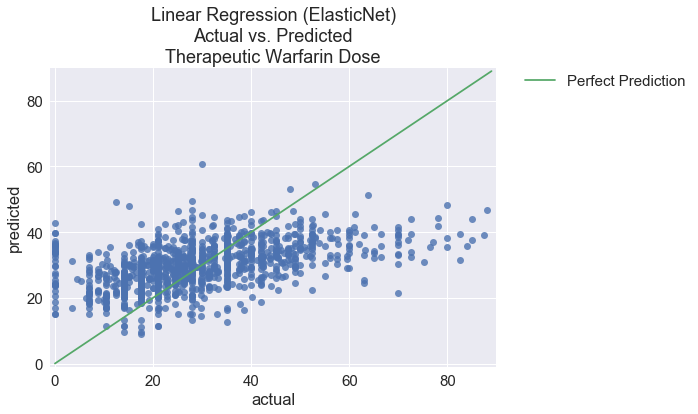

In [83]:
g = sns.regplot(test_y, pred_en, fit_reg=False)
g.set_xlabel("actual")
g.set_ylabel("predicted")
g.set_xlim(left=-1, right=90)
g.set_ylim(bottom=-1, top=90)
line = plt.plot(range(0, 90), label="Perfect Prediction")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_title("Linear Regression (ElasticNet)\nActual vs. Predicted\nTherapeutic Warfarin Dose")

In [84]:
en_score = en.score(test_X, test_y)
print("R2 coefficient: {}".format(en_score))

R2 coefficient: 0.23987573280220828


Oddly, this performed *worse* than ordinary least squares. We can try tuning the alpha parameter. 

In [85]:
alphas = np.arange(0.01, 1.1, 0.01)
l1s = np.arange(0.1, 1.1, 0.1)

In [86]:
models = []
scores = []

for a in alphas:
    for l1 in l1s: 
        en_model = ElasticNet(alpha=a, l1_ratio=l1, random_state=0).fit(train_X, train_y)
        score = en_model.score(test_X, test_y)
        models.append(en_model)
        scores.append(score)

In [87]:
best_score_idx = np.argmax(scores)

In [88]:
models[best_score_idx]

ElasticNet(alpha=0.02, copy_X=True, fit_intercept=True, l1_ratio=1.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [89]:
best_pred = models[best_score_idx].predict(test_X)

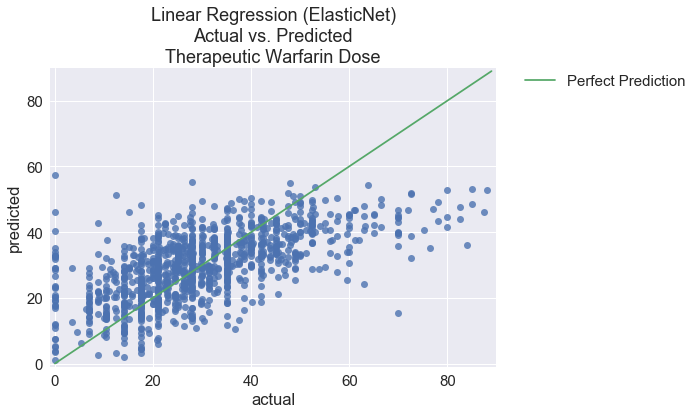

In [90]:
g = sns.regplot(test_y, best_pred, fit_reg=False)
g.set_xlim(left=-1, right=90)
g.set_ylim(bottom=-1, top=90)
line = plt.plot(range(0, 90), label="Perfect Prediction")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xlabel("actual")
g.set_ylabel("predicted")
g.set_title("Linear Regression (ElasticNet)\nActual vs. Predicted\nTherapeutic Warfarin Dose")

In [91]:
best_score = scores[best_score_idx]
print("R2 coefficient: {}".format(best_score))

R2 coefficient: 0.3980401824963078


After tuning, ElasticNet performed the same as ordinary least squares regression.

<br>
<br>

### Tuning SVM C-soft margin parameter
Now, let's try SVM to classify patients with to have high or low doses of warfarin

In [92]:
warf_df["Dose_Type_encoded"] = raw_df["Dose Type"].apply(lambda x: 1 if x == "High" else 0)

In [93]:
train, test = train_test_split(warf_df, test_size=0.2)
print(len(train), len(test))

4560 1140


In [94]:
train_y = train['Dose_Type_encoded']
train_X = train.drop(['Therapeutic Dose of Warfarin', 'Dose_Type_encoded'], axis=1)
test_y = test['Dose_Type_encoded']
test_X = test.drop(['Therapeutic Dose of Warfarin', 'Dose_Type_encoded'], axis=1)

In [95]:
from sklearn.svm import SVC
svc = SVC(C=0.1, kernel='rbf')

In [96]:
svc.fit(train_X, train_y)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
svc_pred = svc.predict(test_X)

In [98]:
high_total = test_y[test_y == 1].count()
low_total = test_y[test_y == 0].count()

In [99]:
tp = sum((test_y == 1) & (svc_pred == 1))
fp = sum((test_y == 0) & (svc_pred == 1))
tn = sum((test_y == 0) & (svc_pred == 0))
fn = sum((test_y == 1) & (svc_pred == 0))

In [100]:
from sklearn.metrics import confusion_matrix
conf_df = pd.DataFrame([[tp, tn], [fp, fn]], columns=["High", "Low"], index=["True", "False"])

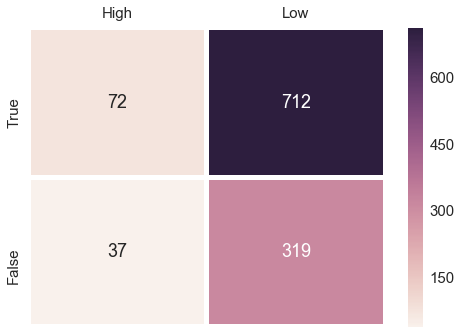

In [101]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots()
sns.heatmap(conf_df, annot=True, fmt="d", linewidths=4, ax=ax)
ax.xaxis.tick_top()

In [102]:
svc_score = svc.score(test_X, test_y)
print("Prediction score: {}".format(svc_score))

Prediction score: 0.6877192982456141


In [103]:
from sklearn.metrics import roc_curve, auc

roc = roc_curve(test_y, svc.decision_function(test_X), pos_label=None, sample_weight=None, drop_intermediate=True)
auc_score = auc(roc[0], roc[1])

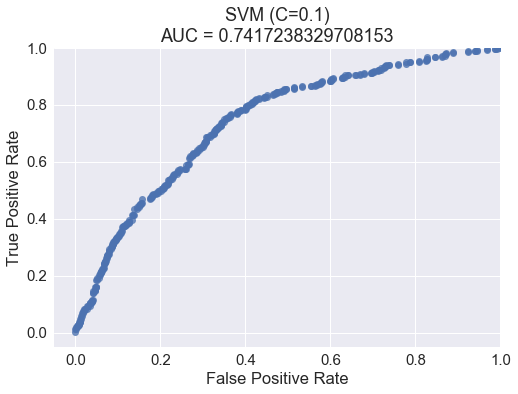

In [104]:
ax1 = sns.regplot(x=roc[0], y=roc[1], fit_reg=False)
ax1.set_xlim(left=-0.05, right=1)
ax1.set_ylim(bottom=-0.05, top=1)
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("SVM (C={})\nAUC = {}".format(0.1, auc_score))

Let's try tuning the C parameter for SVC: 

In [105]:
C_params = np.arange(5, 10)
models = []
scores = []

for c in C_params:
    svc = SVC(C=c, kernel='rbf').fit(train_X, train_y)
    score = svc.score(test_X, test_y)
    models.append(svc)
    scores.append(score)

In [106]:
best_svc_id = np.argmax(scores)

In [107]:
best_model = models[best_svc_id]
best_model

SVC(C=6, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [108]:
scores[best_svc_id]

0.7131578947368421

In [109]:
best_pred = best_model.predict(test_X)

In [110]:
tp = sum((test_y == 1) & (best_pred == 1))
fp = sum((test_y == 0) & (best_pred == 1))
tn = sum((test_y == 0) & (best_pred == 0))
fn = sum((test_y == 1) & (best_pred == 0))

In [111]:
conf_df = pd.DataFrame([[tp, tn], [fp, fn]], columns=["High", "Low"], index=["True", "False"])

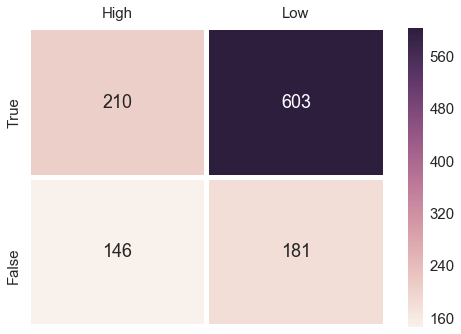

In [112]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots()
sns.heatmap(conf_df, annot=True, fmt="d", linewidths=4, ax=ax)
ax.xaxis.tick_top()

In [113]:
from sklearn.metrics import roc_curve, auc

best_model_roc = roc_curve(test_y, best_model.decision_function(test_X), pos_label=None, sample_weight=None, drop_intermediate=True)
best_model_auc = auc(best_model_roc[0], best_model_roc[1])

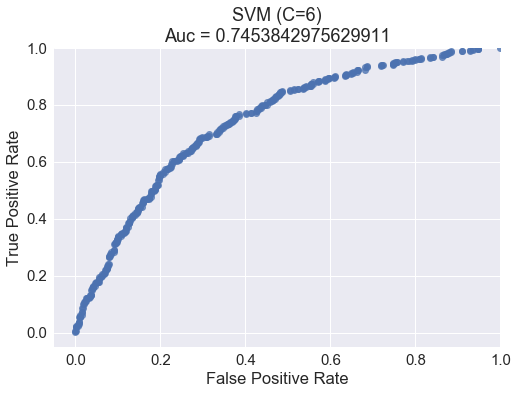

In [114]:
ax2 = sns.regplot(x=best_model_roc[0], y=best_model_roc[1], fit_reg=False)
ax2.set_xlim(left=-0.05, right=1)
ax2.set_ylim(bottom=-0.05, top=1)
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("SVM (C={})\nAuc = {}".format(best_model.get_params()['C'], best_model_auc))

---

# SUMMARY: 
- A/A Variant for VKORC1 is a key factor for Low Dose in Asians, whereas G/G Variant for VKORC1 is a strong indicator for High Dose in Caucasians and African Americans
- It was difficult to train both the regression and SVM classification models to predict high doses. It may be because it has more variablity than low dose observations. 
- Even after tuning the C-soft margin parameter, the model was only able to reach up to 0.745 for AUC. 